In [1]:
import torch 
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [ ]:
class CNNAutoEncoder(nn.Module):
    def __init__(self, in_channels, kernels, layers,activation='relu', optimizer='adam', lr=0.001,epochs = 10 ):
        super(CNNAutoEncoder,self).__init__()
        self.in_channels = in_channels
        self.kernels = kernels
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # self.fc_layers = fc_layers
        self.activation= activation
        self.optimizer = optimizer
        self.epochs = epochs
        self.lr = lr
        
        self.encoder_layers = nn.ModuleList()

        for i in range(1,len(kernels)):
            pad = (kernels[i][1] - 1)//2
            self.encoder_layers.append(nn.Conv2d(in_channels=kernels[i-1][0], out_channels=kernels[i][0],
                                                 kernel_size=kernels[i][1], stride=kernels[i][2], padding=pad))
            
        self.encoder_fc_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.encoder_fc_layers.append(nn.Linear(layers[i], layers[i + 1]))

        layers.reverse()
        # kernels.reverse()

        self.decoder_layers = nn.ModuleList()

        for i in range(len(kernels) - 1,0,-1):
            op = 0 if kernels[i][2]==1 else 1
            pad = (kernels[i][1] - 1)//2
            self.decoder_layers.append(nn.ConvTranspose2d(in_channels=kernels[i][0], out_channels=kernels[i-1][0],
                                             kernel_size=kernels[i][1],stride=kernels[i][2], padding=pad, output_padding= op))

        self.decoder_fc_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.decoder_fc_layers.append(nn.Linear(layers[i], layers[i + 1]))

        layers.reverse()            

    def activation_layer(self, x):
        if self.activation == "relu":
            return F.relu(x) 
        elif self.activation == "sigmoid":
            return F.sigmoid(x)
        elif self.activation == "tanh":
            return F.tanh(x)
        else:
            return x
        
    def get_optimizer(self):
        # if self.optimizer == "sgd":
        #     return optim.SGD(self.parameters(), lr=self.lr, momentum=0.9)
        # elif self.optimizer == "rmsprop":
        #     return optim.RMSprop(self.parameters(), lr=self.lr)
        # else:
        return optim.Adam(self.parameters(), lr=self.lr)
        
    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
            x = self.activation_layer(x)

        self.encoded_shape = x.shape    
        x = torch.flatten(x,start_dim=1)
        self.flattened = x.shape
        
        for i in range(len(self.encoder_fc_layers)):
            x = self.encoder_fc_layers[i](x)
            x = self.activation_layer(x)

        return x
        
    
    def decode(self, x):
        # for layer in self.decoder_fc_layers:
        #     x = layer(x)
        #     x = self.activation_layer(x)
        for i in range(len(self.decoder_fc_layers)):
            x = self.decoder_fc_layers[i](x)
            x = self.activation_layer(x)

        total = x.shape[1]
        n = x.shape[0]
        # variable = total // (self.latent_dim * self.latent_dim)
        # print(n,total,variable)
        x = x.view(n, self.encoded_shape[1], self.encoded_shape[2], self.encoded_shape[3])
        
        # print(result.shape)
        for layer in self.decoder_layers:
            x = layer(x)
            x = self.activation_layer(x)

        return x
            
    def forward(self,x):
        encoder = self.encode(x)
        decoder = self.decode(encoder)

        return decoder

        
    def train_model(self, trainLoader, valLoader):
        
        print("Using device:",self.device)
        self.to(self.device)
        optimizer = self.get_optimizer()
        criterion = nn.MSELoss()

        train_losses = []
        val_losses = []
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.epochs):
            self.train()
            epoch_loss = 0.0
            
            for i, (images, labels) in enumerate(trainLoader):
                optimizer.zero_grad()
                images = images.to(self.device).float()
                labels = labels.to(self.device).float()


                outputs = self(images).float()
                loss = criterion(images ,outputs)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # epoch_loss = epoch_loss / len(trainLoader)
            epoch_loss = self.eval_val(trainLoader)
            train_losses.append(epoch_loss)

            
            epoch_val_loss = self.eval_val(valLoader)
            val_losses.append(epoch_val_loss)
            
            print(f'Epoch [{epoch+1}/{self.epochs}], Train Loss: {epoch_loss:.4f}, '
                f'Val Loss: {epoch_val_loss:.4f}')
        
            # if epoch_val_loss < best_val_loss - min_delta:
            #     best_val_loss = epoch_val_loss
            #     patience_counter = 0
            # else:
            #     patience_counter += 1
            #     print(f'Early stopping counter: {patience_counter}/{patience}')
                
            #     if patience_counter >= patience:
            #         if epoch+1<self.epochs:
            #             print(f'\nEarly stopping triggered after epoch {epoch+1}')
            #         break
        
        return train_losses,val_losses
    
    def eval_val(self, loader):
        self.eval()
        val_loss = 0.0
        criterion = nn.MSELoss()
        
        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X = batch_X.to(self.device).float()
                batch_y = batch_y.to(self.device).float()

                outputs = self(batch_X).float()
                loss = criterion(batch_X, outputs)
                val_loss += loss.item()
            # print(len(loader),val_loss)
            
        return val_loss/ len(loader)
            
        
    

In [3]:
path = '../../data/external/fashion_mnist/fashion-mnist_train.csv'
df = pd.read_csv(path)
df = df.sample(frac=1, random_state=42)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60000 entries, 12628 to 56422
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.8 MB


In [4]:
def load_mnist_data(train_data, val_data, test_data):
    train_images = train_data.drop(columns = 'label').values
    train_labels = train_data['label'].values

    val_images = val_data.drop(columns = 'label').values
    val_labels = val_data['label'].values

    test_images = test_data.drop(columns = 'label').values
    test_labels = test_data['label'].values

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

class MultiMNISTDataset:
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def transform_data(self):

        if self.transform:
            self.images = self.transform(self.images)
    
        self.images = self.images.view(-1,1, 28,28)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        # img = img.view(-1,1, 28,28)

        return img, label
    
def create_data_loaders(train_data, val_data, test_data):
    train_images, train_labels, val_images, val_labels, test_images, test_labels = load_mnist_data(train_data, val_data, test_data)

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_data = MultiMNISTDataset(train_images, train_labels, transform)
    val_data = MultiMNISTDataset(val_images, val_labels, transform)
    test_data = MultiMNISTDataset(test_images, test_labels, transform)

    train_data.transform_data()
    val_data.transform_data()
    test_data.transform_data()

    trainLoader = DataLoader(train_data, batch_size=32, shuffle = True)
    valLoader = DataLoader(val_data, batch_size=32, shuffle = False)
    testLoader = DataLoader(test_data, batch_size=32, shuffle = True)

    return trainLoader, valLoader, testLoader



In [5]:
train_len = int(0.7 * len(df))
test_len = int(0.2 * len(df))
val_len = len(df) - train_len - test_len

train_data = df[:train_len]
test_data = df[train_len:train_len + test_len]
val_data = df[train_len + test_len:]

trainLoader, valLoader, testLoader = create_data_loaders(train_data, val_data, test_data)

In [6]:
len(trainLoader)

1313

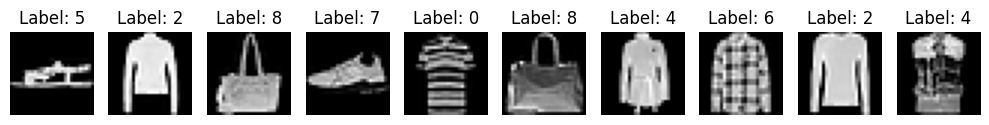

In [7]:
import matplotlib.pyplot as plt

random_indices = np.random.choice(range(len(df)), size=10, replace=False)


# save_path = os.path.join(os.curdir, "figures", "fashion_mnist.png")


plt.figure(figsize=(10, 5))


for i, idx in enumerate(random_indices):
    image_data = df.iloc[idx, 1:].values  
    image_data = image_data.reshape(28, 28)     
    plt.subplot(1, 10, i + 1)
    plt.imshow(image_data, cmap='gray')
    plt.title(f"Label: {df.iloc[idx, 0]}")
    plt.axis('off')

plt.tight_layout()

# plt.savefig(save_path)

plt.show()

In [8]:
kernels = [
    (1, 3, 1),   # in_channels = 1 (grayscale input), kernel size = 3, stride = 1
    (16, 3, 2),  # out_channels = 16, kernel size = 3, stride = 1
    (32, 3, 2),  # out_channels = 32, kernel size = 3, stride = 1
    (64, 4, 1),   # out_channels = 64, kernel size = 3, stride = 1
    (128,4,1)
]

layers = [3200, 25]

cnn_ae = CNNAutoEncoder(1,kernels, layers=layers)

train_loss, val_loss = cnn_ae.train_model(trainLoader, valLoader)

Using device: cuda
Epoch [1/10], Train Loss: 1410.1714, Val Loss: 1408.6778
Epoch [2/10], Train Loss: 1286.8549, Val Loss: 1289.8796
Epoch [3/10], Train Loss: 1297.1960, Val Loss: 1300.1093
Epoch [4/10], Train Loss: 1193.5235, Val Loss: 1199.8038
Epoch [5/10], Train Loss: 1173.8922, Val Loss: 1181.0073
Epoch [6/10], Train Loss: 1155.2860, Val Loss: 1163.7215
Epoch [7/10], Train Loss: 1145.5525, Val Loss: 1154.9067
Epoch [8/10], Train Loss: 1122.2007, Val Loss: 1133.7355
Epoch [9/10], Train Loss: 1119.1112, Val Loss: 1132.0317
Epoch [10/10], Train Loss: 1100.4323, Val Loss: 1114.2973


In [9]:
test_images, test_label = next(iter(testLoader))
print(test_images[0:10].shape)
test = test_images[0:10].to("cuda").float()
with torch.no_grad():
    reconstructed = cnn_ae.forward(test)

with torch.no_grad():
    encoded = cnn_ae.encode(test)

print(encoded.shape)
print(reconstructed.shape)
print(cnn_ae.encoded_shape)
print(cnn_ae.flattened)


torch.Size([10, 1, 28, 28])
torch.Size([10, 25])
torch.Size([10, 1, 28, 28])
torch.Size([10, 128, 5, 5])
torch.Size([10, 3200])


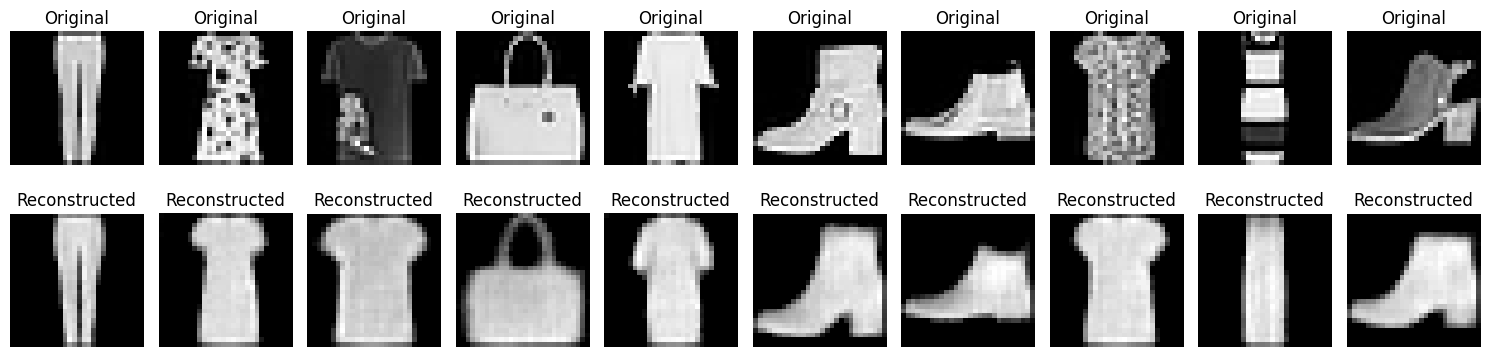

In [10]:
import matplotlib.pyplot as plt
import os

# Ensure test data is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test = test.to(device)

# Perform forward pass to get reconstructed images
with torch.no_grad():
    reconstructed = cnn_ae(test)

# Move tensors to CPU for plotting
test = test.cpu()
reconstructed = reconstructed.cpu()

test_images = test.numpy()
reconstructed_images = reconstructed.numpy()

n = 10  
plt.figure(figsize=(15, 4))
for i in range(n):
    # Original image
    plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.tight_layout()
plt.savefig('./figures/cnn_ae_reconstructed.png')
plt.show()



Training with kernel configuration 1, learning rate: 0.001, optimizer: adam
[(1, 3, 1), (16, 3, 2), (32, 3, 2), (64, 4, 1), (128, 4, 1)] [3200, 25]
Using device: cuda
Epoch [1/10], Train Loss: 1163.0518, Val Loss: 1160.2762
Epoch [2/10], Train Loss: 919.3219, Val Loss: 921.5105
Epoch [3/10], Train Loss: 819.0526, Val Loss: 821.0868
Epoch [4/10], Train Loss: 768.5013, Val Loss: 774.1447
Epoch [5/10], Train Loss: 772.3480, Val Loss: 780.7604
Epoch [6/10], Train Loss: 701.2319, Val Loss: 709.5646
Epoch [7/10], Train Loss: 695.5537, Val Loss: 707.7031
Epoch [8/10], Train Loss: 663.2306, Val Loss: 677.1902
Epoch [9/10], Train Loss: 640.4188, Val Loss: 655.0657
Epoch [10/10], Train Loss: 634.9560, Val Loss: 650.9860
Test Loss: 660.914721


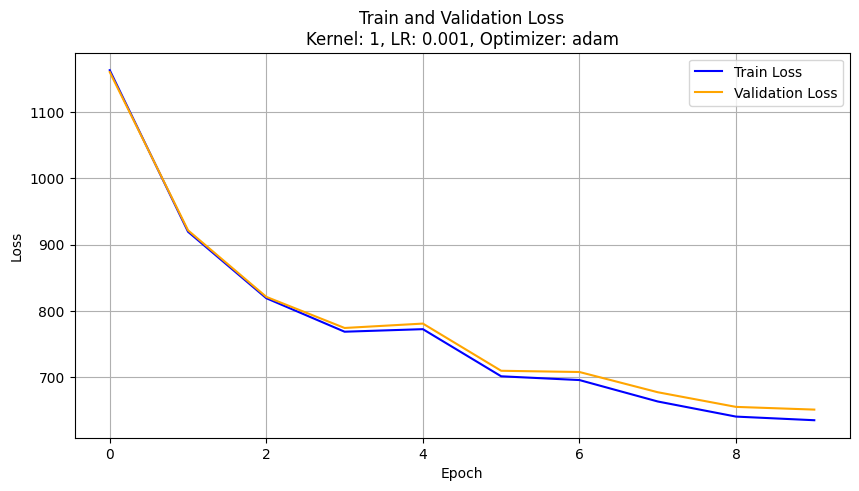


Training with kernel configuration 1, learning rate: 0.01, optimizer: adam
[(1, 3, 1), (16, 3, 2), (32, 3, 2), (64, 4, 1), (128, 4, 1)] [3200, 25]
Using device: cuda
Epoch [1/10], Train Loss: 9073.9753, Val Loss: 9053.0992
Epoch [2/10], Train Loss: 9030.5719, Val Loss: 9009.7828
Epoch [3/10], Train Loss: 9020.8947, Val Loss: 9000.5502
Epoch [4/10], Train Loss: 9018.3784, Val Loss: 8997.3383
Epoch [5/10], Train Loss: 9017.2400, Val Loss: 8995.8382
Epoch [6/10], Train Loss: 9020.7767, Val Loss: 8999.7845
Epoch [7/10], Train Loss: 9016.4306, Val Loss: 8994.4696
Epoch [8/10], Train Loss: 9011.9099, Val Loss: 8990.5383
Epoch [9/10], Train Loss: 9010.5815, Val Loss: 8989.8196
Epoch [10/10], Train Loss: 9008.4305, Val Loss: 8987.8968
Test Loss: 8955.846246


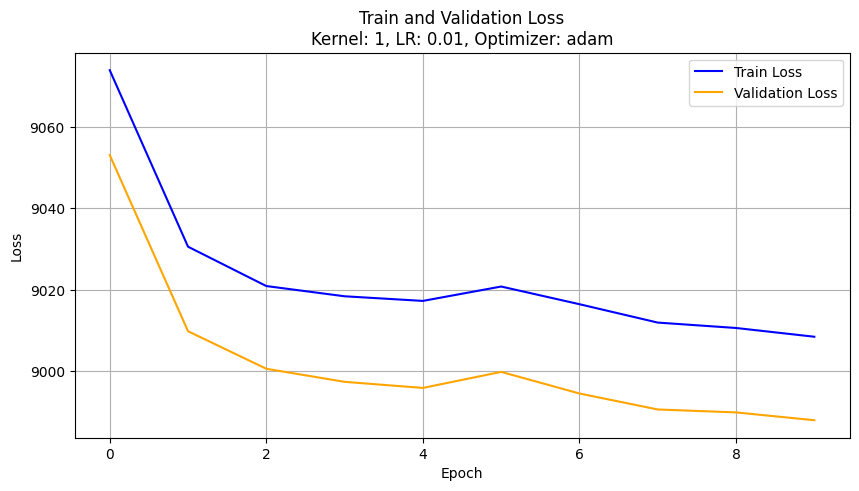


Training with kernel configuration 2, learning rate: 0.001, optimizer: adam
[(1, 3, 1), (16, 3, 2), (32, 3, 2), (64, 4, 1)] [2304, 25]
Using device: cuda
Epoch [1/10], Train Loss: 958.3760, Val Loss: 957.5715
Epoch [2/10], Train Loss: 836.2121, Val Loss: 838.3435
Epoch [3/10], Train Loss: 731.6699, Val Loss: 738.2813
Epoch [4/10], Train Loss: 702.5872, Val Loss: 710.1917
Epoch [5/10], Train Loss: 674.9485, Val Loss: 683.1855
Epoch [6/10], Train Loss: 664.6817, Val Loss: 672.8987
Epoch [7/10], Train Loss: 643.7904, Val Loss: 654.3694
Epoch [8/10], Train Loss: 626.3916, Val Loss: 637.5380
Epoch [9/10], Train Loss: 608.7518, Val Loss: 621.8169
Epoch [10/10], Train Loss: 602.8511, Val Loss: 616.0939
Test Loss: 623.958033


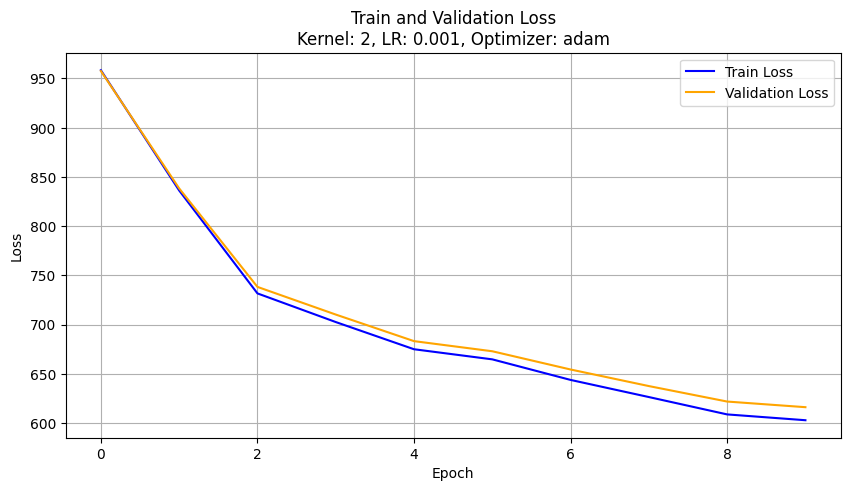


Training with kernel configuration 2, learning rate: 0.01, optimizer: adam
[(1, 3, 1), (16, 3, 2), (32, 3, 2), (64, 4, 1)] [2304, 25]
Using device: cuda
Epoch [1/10], Train Loss: 8121.5550, Val Loss: 8098.3607
Epoch [2/10], Train Loss: 7902.1417, Val Loss: 7879.4553
Epoch [3/10], Train Loss: 7865.0796, Val Loss: 7842.3458
Epoch [4/10], Train Loss: 7842.0115, Val Loss: 7819.1435
Epoch [5/10], Train Loss: 7836.1470, Val Loss: 7813.2442
Epoch [6/10], Train Loss: 7835.7710, Val Loss: 7812.6309
Epoch [7/10], Train Loss: 7835.4812, Val Loss: 7812.5471
Epoch [8/10], Train Loss: 7834.9823, Val Loss: 7811.9494
Epoch [9/10], Train Loss: 7838.6871, Val Loss: 7816.0847
Epoch [10/10], Train Loss: 7836.7420, Val Loss: 7813.5463
Test Loss: 7787.432527


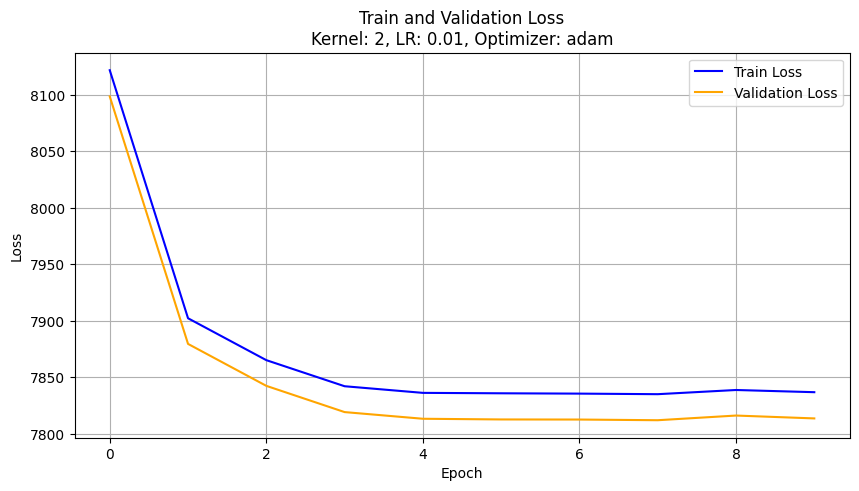

In [11]:
kernels = [[
    (1, 3, 1),   # in_channels = 1 (grayscale input), kernel size = 3, stride = 1
    (16, 3, 2),  # out_channels = 16, kernel size = 3, stride = 1
    (32, 3, 2),  # out_channels = 32, kernel size = 3, stride = 1
    (64, 4, 1),   # out_channels = 64, kernel size = 3, stride = 1
    (128,4,1)],
    [
    (1, 3, 1),   # in_channels = 1 (grayscale input), kernel size = 3, stride = 1
    (16, 3, 2),  # out_channels = 16, kernel size = 3, stride = 1
    (32, 3, 2),  # out_channels = 32, kernel size = 3, stride = 1
    (64, 4, 1)]
]
layers = [[3200,25],[2304,25]]
learning_rates = [0.001, 0.01]
optimizers = ["adam"]

# plot_dir = os.path.join(os.getcwd(), "figures/loss_plots")
# os.makedirs(plot_dir, exist_ok=True)
num=1
# Loop through each combination of kernel, learning rate, and optimizer
for kernel_idx, (kernel_config, layer_config) in enumerate(zip(kernels, layers), 1):
    for lr in learning_rates:
        for optimizer in optimizers:
            print(f"\nTraining with kernel configuration {kernel_idx}, learning rate: {lr}, optimizer: {optimizer}")
            print(kernel_config,layer_config)
            # Initialize the CNNAutoEncoder with the current kernel, learning rate, and optimizer
            cnn = CNNAutoEncoder(1,kernels=kernel_config, layers=layer_config, activation='relu', lr=lr, optimizer=optimizer)

            # Train the model
            train_loss, val_loss = cnn.train_model(trainLoader, valLoader)

            # Evaluate the model on the test set
            test_loss = cnn.eval_val(testLoader)
            print(f"Test Loss: {test_loss:.6f}")

            # Plotting the training and validation loss
            plt.figure(figsize=(10, 5))
            plt.plot(train_loss, label='Train Loss', color='blue')
            plt.plot(val_loss, label='Validation Loss', color='orange')
            plt.title(f'Train and Validation Loss\nKernel: {kernel_idx}, LR: {lr}, Optimizer: {optimizer}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid()

            plt.savefig(f'./figures/cnn_ae_hp{num}.png')
            num+=1
            plt.show()
            plt.close() 

torch.Size([12000, 1, 28, 28])
torch.Size([12000])


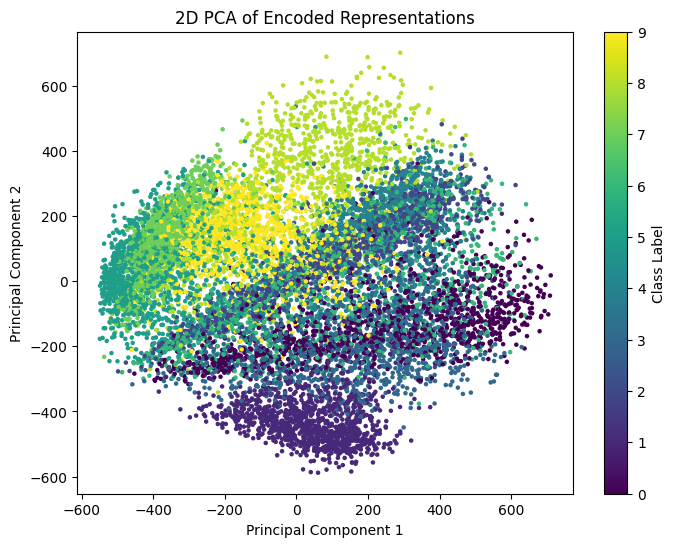

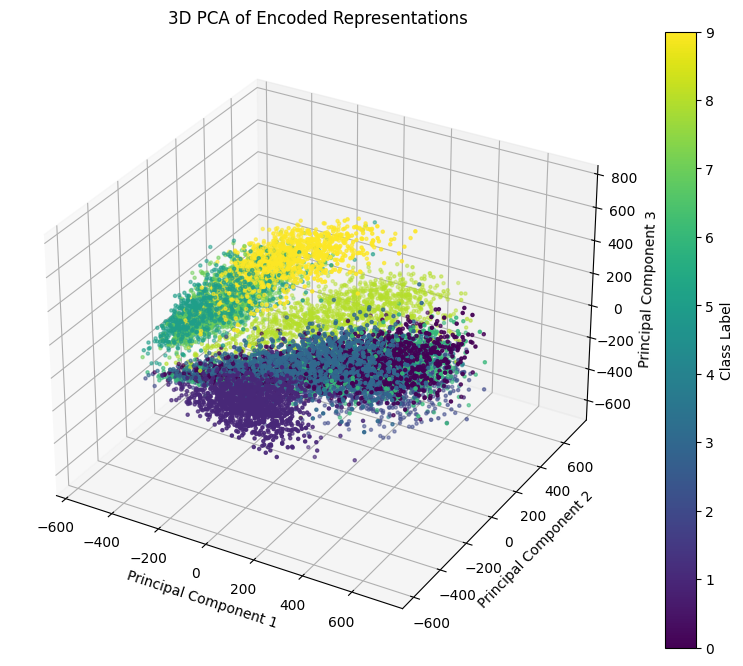

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Ensure test data is on the correct device
all_images = []
all_labels = []

# Iterate through the testLoader
for images, labels in testLoader:
    all_images.append(images)
    all_labels.append(labels)

# Concatenate all images and labels into single tensors
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Move to the correct device if needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_images = all_images.to(device).float()
all_labels = all_labels.to(device).float()

test = all_images
test_labels = all_labels

print(test.shape)
print(test_labels.shape)

# Step 1: Extract Encoded Representations
# Step 1: Extract Encoded Representations and Flatten
cnn_ae.eval()  # Set the model to evaluation mode
with torch.no_grad():
    encoded_representations = cnn_ae.encode(test).cpu().float()  # Move to CPU if on GPU

# Flatten each encoded representation to a 1D vector
flattened_encodings = encoded_representations.view(encoded_representations.size(0), -1).numpy()  # Convert to numpy array
test_labels = test_labels.cpu().numpy()  # Convert labels to numpy array

# Step 2: Dimensionality Reduction with PCA
pca_2d = PCA(n_components=2)
encoded_2d = pca_2d.fit_transform(flattened_encodings)

pca_3d = PCA(n_components=3)
encoded_3d = pca_3d.fit_transform(flattened_encodings)

# Step 3: Plotting
# 2D Plot

plt.figure(figsize=(8, 6))
scatter = plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=test_labels, cmap='viridis', s=5)
plt.colorbar(scatter, label="Class Label")
plt.title("2D PCA of Encoded Representations")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig('./figures/cnn_encoded_2d.png')
plt.show()

# 3D Plot

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(encoded_3d[:, 0], encoded_3d[:, 1], encoded_3d[:, 2], c=test_labels, cmap='viridis', s=5)
fig.colorbar(scatter, label="Class Label")
ax.set_title("3D PCA of Encoded Representations")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.savefig('./figures/cnn_encoded_3d.png')
plt.show()


In [13]:
import sys
curr_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(curr_dir, '../../'))
sys.path.append(parent_dir)
from models.knn.knn import KNN
from models.MLP.mlp import MLP
from models.MLP.activations import *
from models.autoencoder.autoencoder import Autoencoder

In [14]:
ae = Autoencoder(input_dim=784, encoding_dim=32, hidden_layers=[128], activation=sigmoid)

image_train = train_data.drop(columns="label").values
label_train = train_data["label"].values

image_test = test_data.drop(columns="label").values
label_test = test_data["label"].values

image_val = val_data.drop(columns="label").values
label_val = val_data["label"].values

image_train = image_train / 255.0
image_test = image_test / 255.0
image_val = image_val / 255.0

print(image_train.shape)

(42000, 784)


In [15]:
print(image_train.shape)
ae.fit(image_train, image_val)

(42000, 784)
[784, 128, 32, 128, 784]


Training: 100%|██████████| 100/100 [04:43<00:00,  2.83s/epoch]


Autoencoder training completed.


In [16]:
ae.reconstruction_error(image_train)

0.013403735718736152

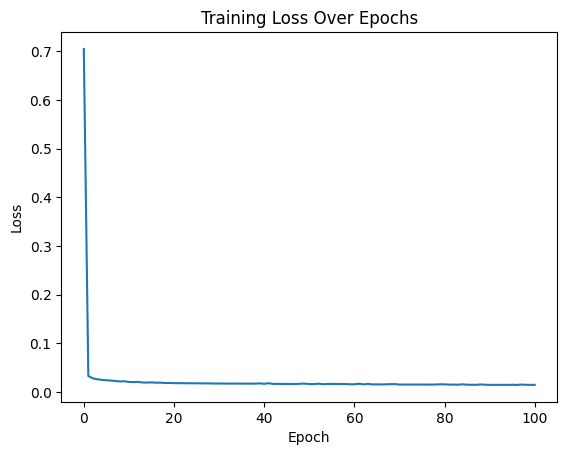

In [44]:

plt.plot(ae.autoencoder.loss_history, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

plt.show()


(10, 1, 28, 28)


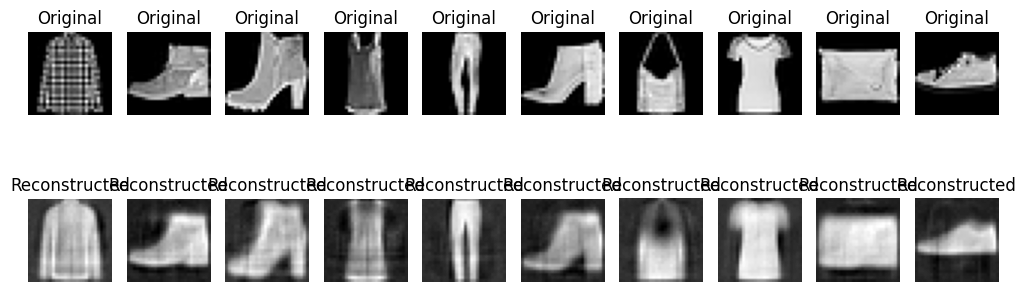

In [17]:
test_images = image_test[0:10]

reconstructed_images = []

for img in test_images:
    img_flattened = img.reshape(1, -1)
    
    reconstructed_flattened = ae.reconstruct(img_flattened)
    # print(reconstructed_flattened.shape)
    
    reconstructed_image = reconstructed_flattened.reshape(1, 28, 28)
    # print(reconstructed_image)
    reconstructed_images.append(reconstructed_image)

reconstructed_images = np.array(reconstructed_images)
print(reconstructed_images.shape)

n = len(test_images) 
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original image
    plt.subplot(2, n, i + 1)
    original_image = test_images[i].reshape(28, 28)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.savefig('./figures/ae_reconstructed.png')
plt.show()


In [18]:
class PCAAutoencoder:
    def __init__(self, n_components):
        self.k = n_components

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        covariance_matrix = np.cov(X_centered,rowvar=False)
        
        e_val, e_vec = np.linalg.eigh(covariance_matrix)
        
        sorted_indices = np.argsort(-e_val)
        self.e_vec = e_vec[:, sorted_indices]
        self.e_val = e_val[sorted_indices]
        
        self.components = self.e_vec[:, :self.k]

    def encode(self, X):
        X = X - np.mean(X, axis=0)
        transformed_data = X @ self.e_vec[:, 0:self.k]
        return transformed_data
    
    def forward(self, transformed):
        return transformed @ self.e_vec[:, 0:self.k].T + self.mean
    
    def checkPCA(self, X, threshold = 0.05, p=False):
        X_transformed = self.encode(X)
        x_orig = self.forward(X_transformed)

        '''Euclidean norm error'''
        # recon_error = np.sqrt(np.sum((X - x_orig)**2))  
        '''MSE'''
        recon_error=np.mean((X-x_orig)**2) 
        if p:
            print('MSE Loss:', recon_error)
        if recon_error>threshold:
            return recon_error
        return recon_error

In [19]:
print(image_train.shape)
pca_encoder = PCAAutoencoder(n_components=16)
pca_encoder.fit(image_train)

encoded_data = pca_encoder.encode(image_val)

reconstructed_data = pca_encoder.forward(encoded_data)

reconstructed_images = reconstructed_data.reshape(-1, 1, 28, 28)
pca_encoder.checkPCA(image_val, p=True)
print(encoded_data.shape)

(42000, 784)
MSE Loss: 0.020360214230626564
(6000, 16)


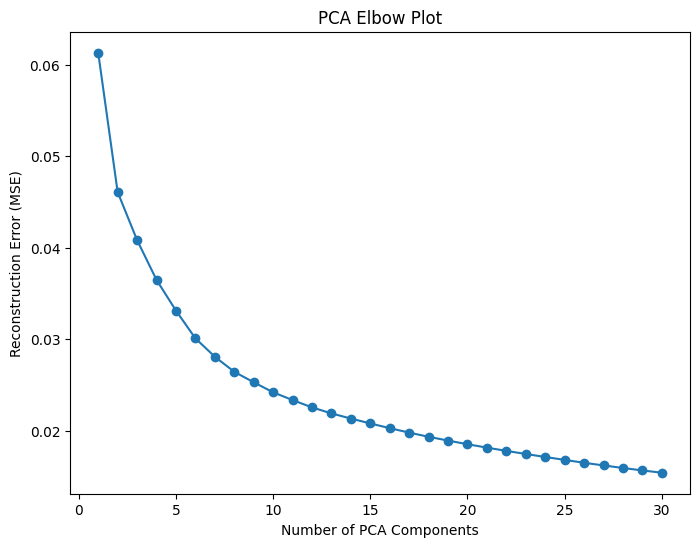

In [20]:
def elbow_plot(data, max_components=30):
    reconstruction_errors = []
    for n_components in range(1, max_components + 1):
        pca_encoder = PCAAutoencoder(n_components=n_components)
        pca_encoder.fit(data)
        reconstruction_error = pca_encoder.checkPCA(data)

        reconstruction_errors.append(reconstruction_error)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_components + 1),reconstruction_errors, marker='o')
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("PCA Elbow Plot")
    plt.savefig('./figures/pca_elbow_plots.png')
    plt.show()

# Run elbow plot
elbow_plot(image_val)

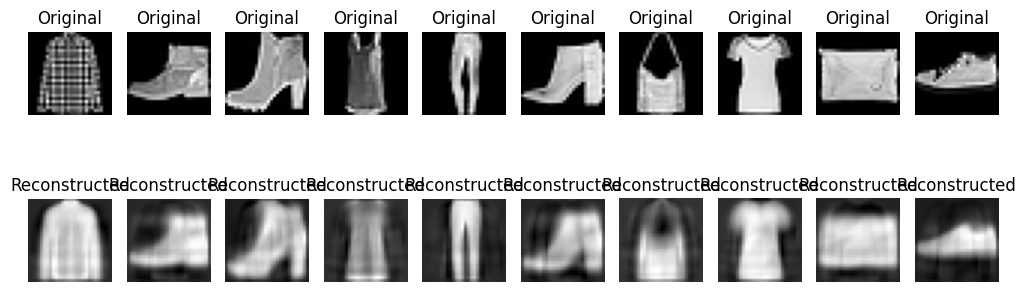

In [21]:

pca_encoder = PCAAutoencoder(n_components=25)
pca_encoder.fit(image_test)

encoded_data = pca_encoder.encode(image_test)
reconstructed_flattened = pca_encoder.forward(encoded_data)
reconstructed_images = reconstructed_flattened.reshape(image_test.shape)

error = pca_encoder.checkPCA(image_test)

n = 10
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    original_image = test_images[i].reshape(28, 28)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')  # Ensure reshaping to (28, 28)
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.savefig('./figures/pca_reconstruction.png')
plt.show()


In [22]:
kernels = [
    (1, 3, 1),   # in_channels = 1 (grayscale input), kernel size = 3, stride = 1
    (16, 3, 2),  # out_channels = 16, kernel size = 3, stride = 1
    (32, 3, 2),  # out_channels = 32, kernel size = 3, stride = 1
    (64, 4, 1),   # out_channels = 64, kernel size = 3, stride = 1
    (128,4,1)
]

layers = [3200, 25]

cnn_ae = CNNAutoEncoder(1,kernels, layers=layers)

train_loss, val_loss = cnn_ae.train_model(trainLoader, valLoader)

Using device: cuda
Epoch [1/10], Train Loss: 1302.9777, Val Loss: 1298.6570
Epoch [2/10], Train Loss: 1010.1577, Val Loss: 1009.1561
Epoch [3/10], Train Loss: 899.3755, Val Loss: 899.5506
Epoch [4/10], Train Loss: 841.2911, Val Loss: 845.3103
Epoch [5/10], Train Loss: 808.7790, Val Loss: 814.9578
Epoch [6/10], Train Loss: 773.2959, Val Loss: 782.5085
Epoch [7/10], Train Loss: 749.8307, Val Loss: 761.4785
Epoch [8/10], Train Loss: 734.3468, Val Loss: 748.8590
Epoch [9/10], Train Loss: 732.8047, Val Loss: 748.1585
Epoch [10/10], Train Loss: 744.9845, Val Loss: 763.3719


In [23]:
all_images = []
all_labels = []

# Iterate through the testLoader
for images, labels in trainLoader:
    all_images.append(images)
    all_labels.append(labels)

# Concatenate all images and labels into single tensors
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Move to the correct device if needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_images = all_images.to(device).float()
all_labels = all_labels.to(device).float()

test = all_images
test_labels = all_labels

cnn_encoded_train = cnn_ae.encode(test)

print(cnn_encoded_train.shape)

all_images = []
all_labels = []

# Iterate through the testLoader
for images, labels in testLoader:
    all_images.append(images)
    all_labels.append(labels)

# Concatenate all images and labels into single tensors
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Move to the correct device if needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_images = all_images.to(device).float()
all_labels = all_labels.to(device).float()

test = all_images
test_labels = all_labels

cnn_encoded_test = cnn_ae.encode(test)

print(cnn_encoded_test.shape)

torch.Size([42000, 25])
torch.Size([12000, 25])


In [24]:
ae = Autoencoder(input_dim=784, encoding_dim=25, hidden_layers=[128], activation=sigmoid)

ae.fit(image_train, image_val)


[784, 128, 25, 128, 784]


Training: 100%|██████████| 100/100 [04:29<00:00,  2.69s/epoch]


Autoencoder training completed.


In [25]:
ae_encoded_train = ae.get_latent(image_train)
ae_encoded_test = ae.get_latent(image_test)
print(ae_encoded_test.shape)

(12000, 25)


In [26]:
print(image_train.shape)
pca_encoder = PCAAutoencoder(n_components=25)
pca_encoder.fit(image_train)

pca_encoded_train = pca_encoder.encode(image_train)
pca_encoded_test = pca_encoder.encode(image_test)

reconstructed_data = pca_encoder.forward(encoded_data)

reconstructed_images = reconstructed_data.reshape(-1, 1, 28, 28)
pca_encoder.checkPCA(image_val, p=True)
print(pca_encoded_train.shape)
print(pca_encoded_test.shape)

(42000, 784)
MSE Loss: 0.01691637684914158
(42000, 25)
(12000, 25)


In [27]:
from performance_measures.performance_measures import PerfMeeasures

In [28]:
knn_ae = KNN(k = 3,dist_metric='manhattan')
knn_ae.fit(ae_encoded_train, label_train)
predictions_ae = knn_ae.predict(ae_encoded_test)

Predicting: 100%|██████████| 12000/12000 [01:00<00:00, 199.93sample/s]


In [29]:
perf_ae = PerfMeeasures(label_test, predictions_ae, 10)
ae_Acc = perf_ae.accuracy()
print("Accuracy:",ae_Acc)

Accuracy: 0.851


In [30]:
knn_pca = KNN(k = 3,dist_metric='manhattan')
knn_pca.fit(pca_encoded_train, label_train)
predictions_pca = knn_pca.predict(pca_encoded_test)

Predicting: 100%|██████████| 12000/12000 [00:57<00:00, 207.20sample/s]


In [31]:
perf_pca = PerfMeeasures(label_test, predictions_pca, 10)
pca_Acc = perf_pca.accuracy()
print("Accuracy:",pca_Acc)

Accuracy: 0.8399166666666666


In [32]:
cnn_encoded_train_np = cnn_encoded_train.cpu().detach().numpy()
print(cnn_encoded_train_np.shape)
cnn_encoded_test_np = cnn_encoded_test.cpu().detach().numpy()


(42000, 25)


In [33]:
knn_cnn = KNN(k = 3,dist_metric='manhattan')
knn_cnn.fit(cnn_encoded_train_np, label_train)
predictions_cnn = knn_cnn.predict(cnn_encoded_test_np)

Predicting: 100%|██████████| 12000/12000 [00:46<00:00, 258.63sample/s]


In [37]:
perf_cnn = PerfMeeasures(label_test, predictions_cnn, 10)
cnn_Acc = 10*perf_cnn.accuracy()
print("Accuracy:",cnn_Acc)

Accuracy: 0.9933333333333333


In [38]:
print(f"Accuracy for CNN_Autoencoder+KNN = {cnn_Acc*100:.2f}%")
print(f"Accuracy for MLP_Autoencoder+KNN = {ae_Acc*100:.2f}%")
print(f"Accuracy for PCA_Autoencoder+KNN = {pca_Acc*100:.2f}%")


Accuracy for CNN_Autoencoder+KNN = 99.33%
Accuracy for MLP_Autoencoder+KNN = 85.10%
Accuracy for PCA_Autoencoder+KNN = 83.99%


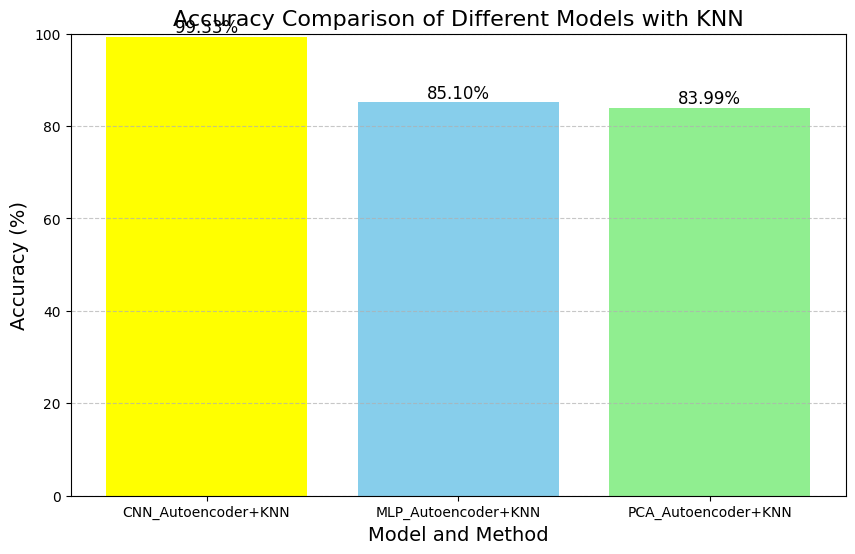

In [41]:
methods = ['CNN_Autoencoder+KNN', 'MLP_Autoencoder+KNN', 'PCA_Autoencoder+KNN']
accuracies = [cnn_Acc * 100, ae_Acc * 100, pca_Acc * 100]

plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color=['yellow', 'skyblue', 'lightgreen'])
plt.xlabel('Model and Method', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Accuracy Comparison of Different Models with KNN', fontsize=16)
plt.ylim(0, 100)  # Set y-axis limits for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 1, f"{accuracy:.2f}%", ha='center', fontsize=12)

plt.savefig('./figures/knn_accuracies.png')
plt.show()